In [1]:
#Imports e configurações
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Usando dispositivo:", DEVICE)


Usando dispositivo: cuda


In [ ]:
# --- Imports e Transformações ---
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

cwru_dir = "../images/CWRU"
hust_dir = "../images/hust"

cwru_dataset = datasets.ImageFolder(root=cwru_dir, transform=transform)
hust_dataset = datasets.ImageFolder(root=hust_dir, transform=transform)

from torch.utils.data import ConcatDataset
combined_dataset = ConcatDataset([cwru_dataset, hust_dataset])

data_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=False)

idx_to_class = {v: k for k, v in cwru_dataset.class_to_idx.items()}


In [8]:
#Modelo treinado (mesma definição do treino)
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

model = ConvAutoencoder().to(DEVICE)
model.eval()


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [9]:
#Avaliação do erro de reconstrução

errors = []
labels = []

criterion = nn.MSELoss(reduction='none')

with torch.no_grad():
    for imgs, lbls in data_loader:
        imgs = imgs.to(DEVICE)
        recon = model(imgs)
        loss = criterion(recon, imgs)
        loss_per_img = loss.view(loss.size(0), -1).mean(dim=1)  # erro médio por imagem
        errors.extend(loss_per_img.cpu().numpy())
        labels.extend(lbls.numpy())

errors = np.array(errors)
labels = np.array(labels)


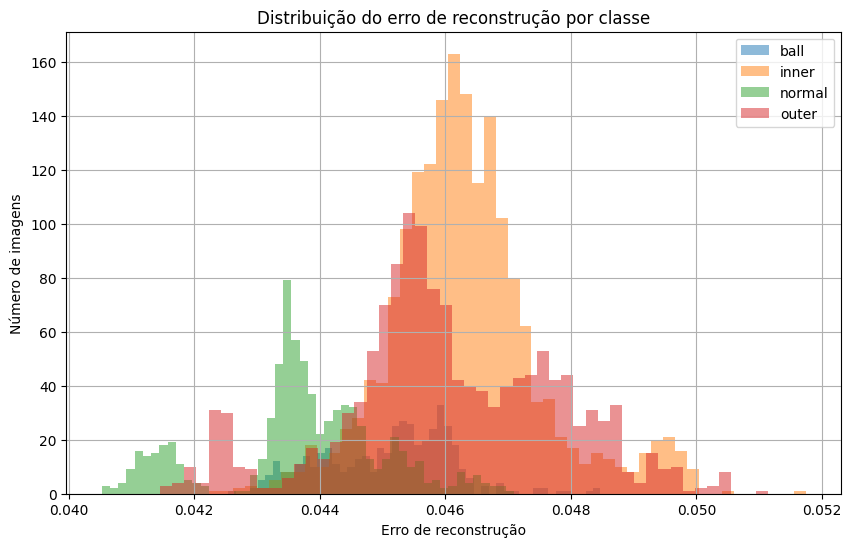

In [10]:
#Histograma do erro por classe
plt.figure(figsize=(10, 6))
for class_idx in np.unique(labels):
    class_mask = labels == class_idx
    plt.hist(errors[class_mask], bins=50, alpha=0.5, label=idx_to_class[class_idx])
plt.xlabel("Erro de reconstrução")
plt.ylabel("Número de imagens")
plt.title("Distribuição do erro de reconstrução por classe")
plt.legend()
plt.grid(True)
plt.show()


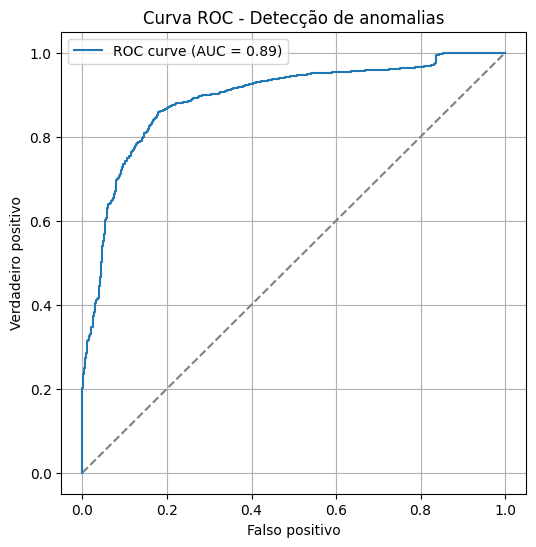

In [35]:

class_to_idx = {v: k for k, v in idx_to_class.items()}

normal_idx = class_to_idx['normal']
binary_labels = (labels != normal_idx).astype(int)

# Calcular ROC
fpr, tpr, thresholds = roc_curve(binary_labels, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Falso positivo")
plt.ylabel("Verdadeiro positivo")
plt.title("Curva ROC - Detecção de anomalias")
plt.legend()
plt.grid(True)
plt.show()

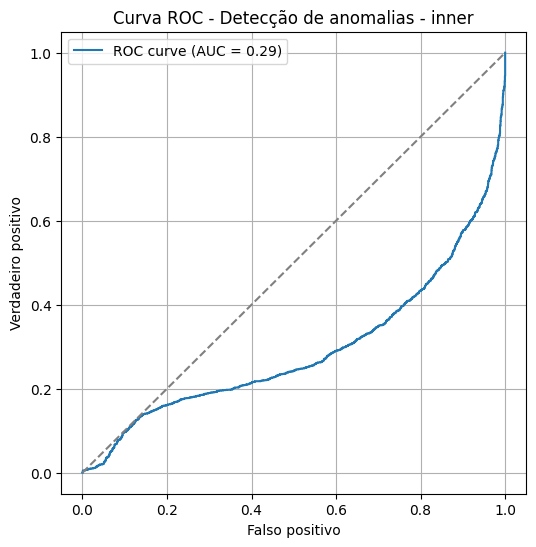

In [36]:
inner_idx = class_to_idx['inner']
binary_labels = (labels != inner_idx).astype(int)

# Calcular ROC
fpr, tpr, thresholds = roc_curve(binary_labels, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Falso positivo")
plt.ylabel("Verdadeiro positivo")
plt.title("Curva ROC - Detecção de anomalias - inner")
plt.legend()
plt.grid(True)
plt.show()

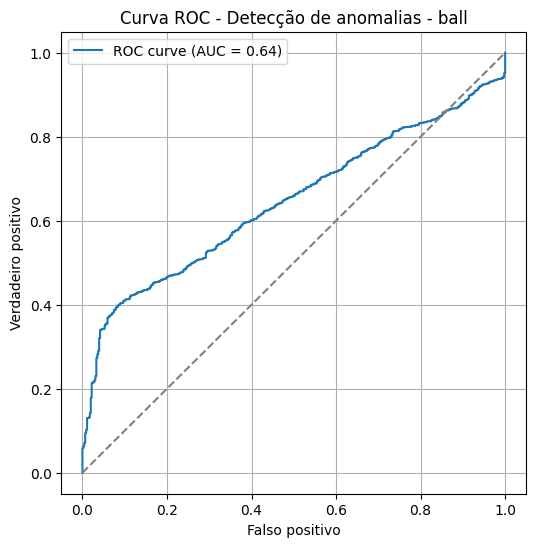

In [37]:

ball_idx = class_to_idx['ball']
binary_labels = (labels != ball_idx).astype(int)

# Calcular ROC
fpr, tpr, thresholds = roc_curve(binary_labels, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Falso positivo")
plt.ylabel("Verdadeiro positivo")
plt.title("Curva ROC - Detecção de anomalias - ball")
plt.legend()
plt.grid(True)
plt.show()

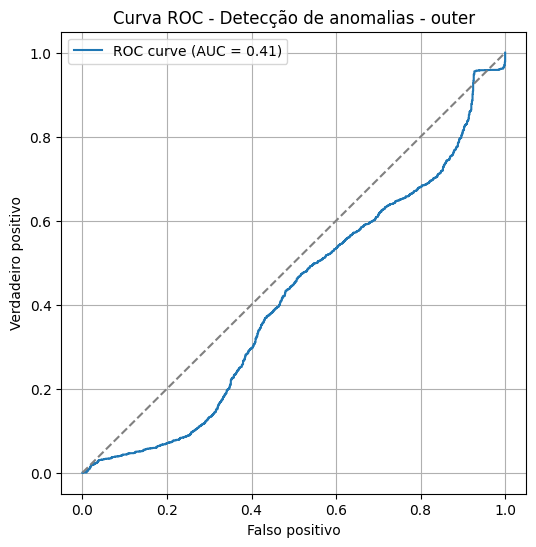

In [38]:
outer_idx = class_to_idx['outer']
binary_labels = (labels != outer_idx).astype(int)

# Calcular ROC
fpr, tpr, thresholds = roc_curve(binary_labels, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Falso positivo")
plt.ylabel("Verdadeiro positivo")
plt.title("Curva ROC - Detecção de anomalias - outer")
plt.legend()
plt.grid(True)
plt.show()